In [2]:
import fastf1 as ff1
import pandas as pd

from style2speed.data import (
    compile_telemetry,
    interpolate_telemetry,
    derive_params
)
from style2speed.stats import (
    calc_param_stats,
)
from style2speed.preprocessing import (
    normalize_telemetry,
    normalize_times,
    build_torch_dataset,
)
from style2speed.models.architectures import (
    TelemetryModelFC,
    TelemetryModelCNN,
    TelemetryModelLSTM,
    TelemetryModelCNNLSTM,
)
from style2speed.models.inference import (
    compare_models
)
from style2speed.plotting.performance import (
    plot_training_curves,
    plot_acc_across_drivers,
    plot_violins,
)
from style2speed.plotting.traces import (
    plot_traces,
    overlay_telemetry_and_importance_traces,
)
from style2speed.plotting.circuit import (
    visualize_circuit,
    visualize_along_circuit_ind_values,
)

### Compile Telemetry Data

In [2]:
# Load session with fastf1
miami_2025 = ff1.get_session(2025, 6, 'R')
miami_2025.load()

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\rober\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cach

In [ ]:
# Compile and save telemetry data
df_tel_raw, df_laptimes = compile_telemetry(miami_2025,
                                            save_path_tel='../data/miami_2025/telemetry_miami_2025.csv',
                                            save_path_time='../data/miami_2025_laptimes_miami_2025.csv')

In [3]:
# Or load if already compiled
df_tel_raw = pd.read_csv('../data/miami_2025/telemetry_miami_2025.csv')
df_laptimes = pd.read_csv('../data/miami_2025/laptimes_miami_2025.csv')

In [4]:
# Interpolate data and derive addtitional parameters
df_tel = interpolate_telemetry(df_tel_raw)
df_tel = derive_params(df_tel)

[INFO] Dropped 18 laps due to insufficient data.


In [5]:
# Calculate segments statistics
df_stats = calc_param_stats(df_tel, segment_length=200.0)

### Train NN Models and Run Inference

In [4]:
# Build torch dataset with normalized full lap data
df_tel_norm = normalize_telemetry(df_tel)
df_laptimes_norm, scaling_params = normalize_times(df_laptimes)
X, y, baseline, trajectory, df_meta, label_to_driver, n_drivers, n_steps, n_params, time_scaling_lap  = (
    build_torch_dataset(df_tel_norm, df_times=df_laptimes_norm)
)

In [ ]:
# Train various models and compare performance
compare_models(
    [TelemetryModelFC, TelemetryModelCNN, TelemetryModelLSTM, TelemetryModelCNNLSTM],
    ['class', 'reg', 'multi'],
    X, y, baseline, trajectory, df_meta, label_to_driver,
    n_drivers, n_steps, n_params,
    batch_size=128, n_trials=5, n_epoch=50,
    save_dir='../data/miami_2023/full_lap/',
    download=False,
    include_lap_attr=False,
)

In [6]:
# Or Load saved inference data
df_metrics = pd.read_csv('../data/miami_2025/full_lap/metrics.csv')
df_pred = pd.read_csv('../data/miami_2025/full_lap/predictions.csv')
df_attr_stats = pd.read_csv('../data/miami_2025/full_lap/attr_stats.csv')

### Comparison of Model Performance

*   **Classification task:** <br>

    Both the fully connected (FC) and convolutional neural network (CNN) models performed well on the classification task, achieving 97% and 99% accuracy, respectively, well within 50 epochs. Their convergence was stable and largely insensitive to weight initialization.

    In contrast, the LSTM and CNN-LSTM models underperformed. The standalone LSTM reached less than 2% accuracy and exhibited highly unstable convergence. Adding a CNN front-end (CNN-LSTM) improved performance, but training remained noisy and sensitive to initialization. Among five trained CNN-LSTM models, the best achieved a final accuracy of only 43%.

*   **Regression task:** <br>

    The overall regression performance of the models was comparable. The final mean squared errors for the FC, CNN, LSTM, and CNN-LSTM models were 0.26, 0.32, 0.37, and 0.22, respectively. Thus, across all models, the final errors remained relatively high—only about several times lower than the theoretical error of ~1.0 expected from random lap time sampling.

    Notably, when prediction errors were visualized across drivers using violin plots, the FC model displayed shorter and wider violins. This suggests that its predictions were the most moderate—less likely to be very close to the true lap time, but also less likely to exhibit large deviations.

    Both the FC and CNN models showed stable convergence and were largely insensitive to initialization. In contrast, the LSTM model exhibited noisy convergence and moderate sensitivity to initialization. The CNN-LSTM model also showed noisy convergence, but this instability was limited to the early epochs of training.

*   **Multi-task (classification + regression):** <br>

    In the combined classification and regression task, both the FC and CNN models maintained performance levels comparable to those achieved in the single-task settings. In contrast, the performance of the recurrent models (LSTM and CNN-LSTM) degraded noticeably in the multi-task context.

*   **Driver-specific performance:** <br>

    When models demonstrated improvements in driver classification or lap time prediction, there was no discernible dependence on driver identity. This suggests that the observed performance gains were generalizable across drivers, rather than being driven by outliers or model specialization to specific individuals.

*   **LIMITATIONS** <br>

    As noted earlier, model performance can be sensitive to weight initialization. To evaluate this variability, five independent training runs were performed for each model architecture and task. However, this represents only a small sample of the broader solution space. As such, some of the conclusions presented here may vary across different training instances.

    In addition, the dataset size may have been insufficient for training the more complex recurrent models—or even the simpler FC and CNN models on the regression task. The dataset comprised telemetry from approximately 20 drivers and 50 laps per driver, totaling around 1,000 laps. This scale may be inadequate for reliably learning the subtle and high-dimensional relationships required by complex architectures or continuous-valued predictions.

In [7]:
df_metrics_best = df_metrics[df_metrics['BestTrial'] == 1]
df_final = df_metrics_best.sort_values(['Epoch']).groupby(['ModelName', 'Task'], as_index=False).last()
df_final

,ModelName,Task,TrainLoss,ValidLoss,Accuracy,MSE,Epoch,Trial,BestTrial
0,TelemetryModelCNN,class,0.062880,0.044105,0.993548,NaN,24,2,1
1,TelemetryModelCNN,multi,0.249366,0.159778,0.993548,0.253163,44,3,1
2,TelemetryModelCNN,reg,0.157531,0.320488,NaN,0.320488,49,0,1
3,TelemetryModelCNNLSTM,class,1.584309,1.468079,0.432258,NaN,49,1,1
4,TelemetryModelCNNLSTM,multi,1.501670,1.537122,0.096774,0.430485,49,4,1
5,TelemetryModelCNNLSTM,reg,0.241712,0.222814,NaN,0.222814,49,1,1
6,TelemetryModelFC,class,0.025836,0.092384,0.974194,NaN,45,1,1
7,TelemetryModelFC,multi,0.155421,0.176652,0.987097,0.257962,49,0,1
8,TelemetryModelFC,reg,0.056395,0.256825,NaN,0.256825,49,1,1
9,TelemetryModelLSTM,class,2.769843,2.780836,0.019355,NaN,10,0,1


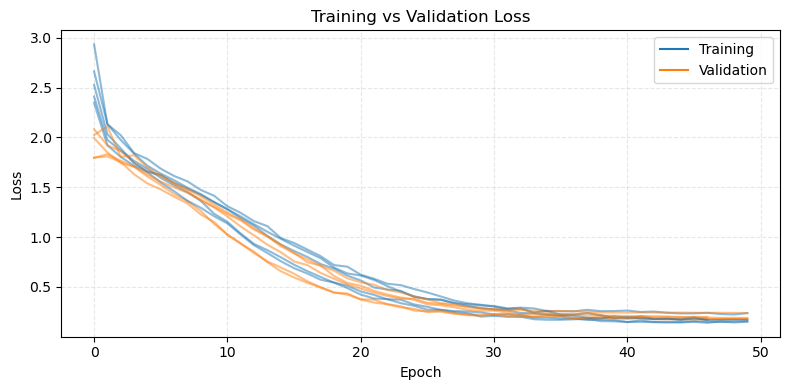

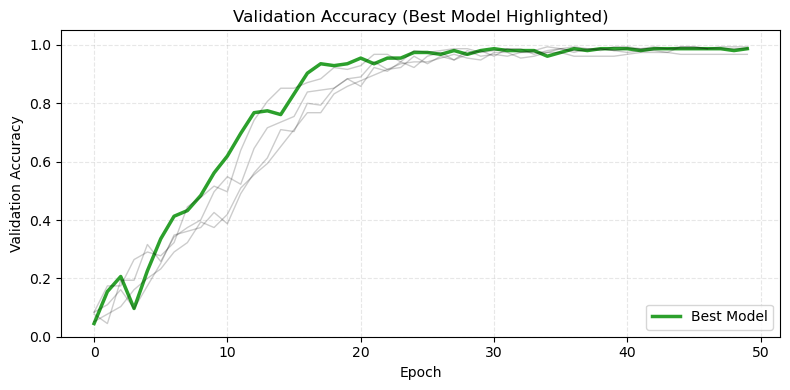

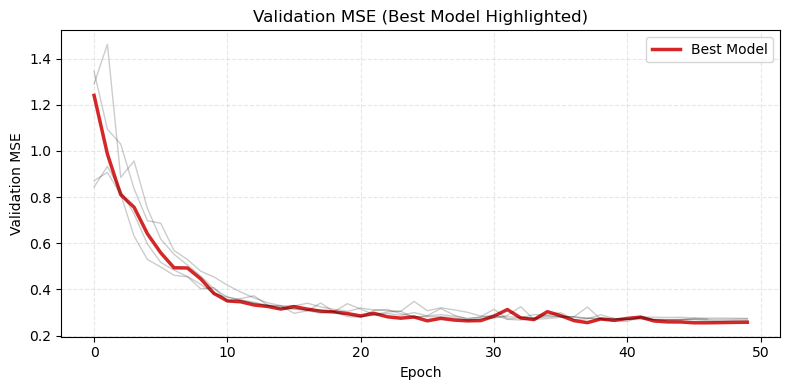

In [8]:
plot_training_curves(
    df_metrics,
    'multi',
    filter_by={'ModelName':['TelemetryModelFC'],
               'Task':['multi']},
    figsize=(8, 4),
)

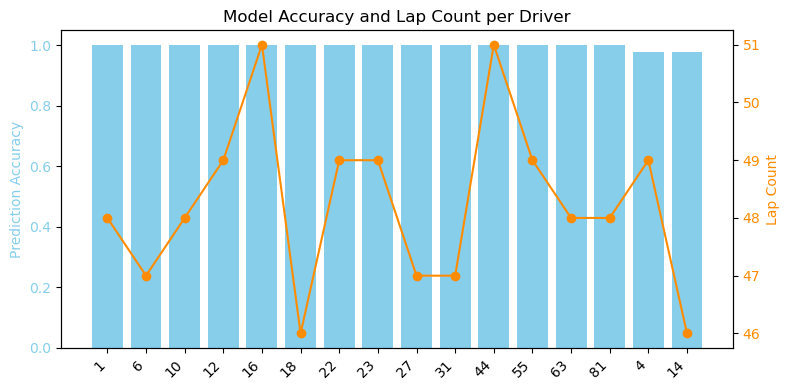

In [9]:
plot_acc_across_drivers(
    df_pred,
    filter_by={'ModelName':['TelemetryModelFC'],
               'Task':['multi']},
    figsize=(8, 4),
)

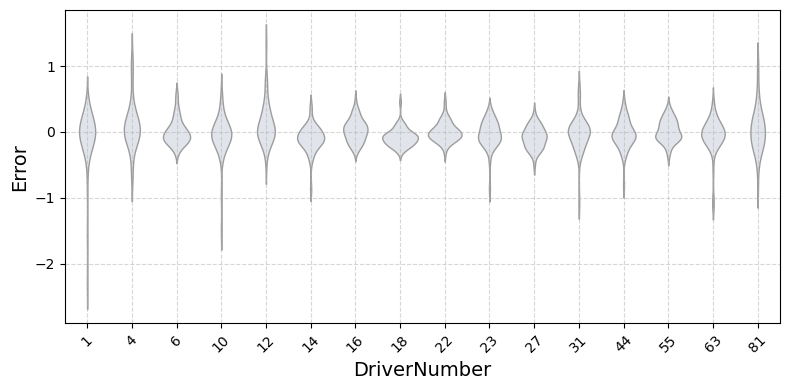

In [10]:
plot_violins(
    df_pred,
    'DriverNumber',
    'Error',
    filter_by={'ModelName':['TelemetryModelFC'],
               'Task':['reg']},
    figsize=(8, 4))

### General Parameter Importance

Across all models, contextual parameters—including Curvature, Radius of Curvature, Lateral Acceleration, and Inverse Following Distance—consistently received low importance scores. Similarly, DRS was also assigned minimal importance, likely because it is infrequently activated by drivers.

Most models—FC, CNN, and LSTM—tended to assign higher importance to parameter changes or derivatives (e.g., GearChange, dSpeed, dRPM, dThrottle) than to their corresponding absolute values (e.g., Gear, Speed, RPM, Throttle). A notable exception was Brake, where the absolute value received more importance than its derivative (BrakeChange).

In contrast, CNN-LSTM models distributed importance more evenly between raw values and their derivatives. This likely reflects their ability to capture temporal dependencies, where both the magnitude of a signal and its changes over time contribute meaningfully to prediction.

**LIMITATIONS**

Some input parameters—especially those with functional or statistical overlap (e.g., Gear and GearChange, or Brake, GearChange, and dSpeed)—may be redundant at specific circuit positions. As a result, a model’s low attribution to a particular parameter does not necessarily imply it is unimportant; rather, the model may have learned to rely more heavily on one representative from a redundant group.

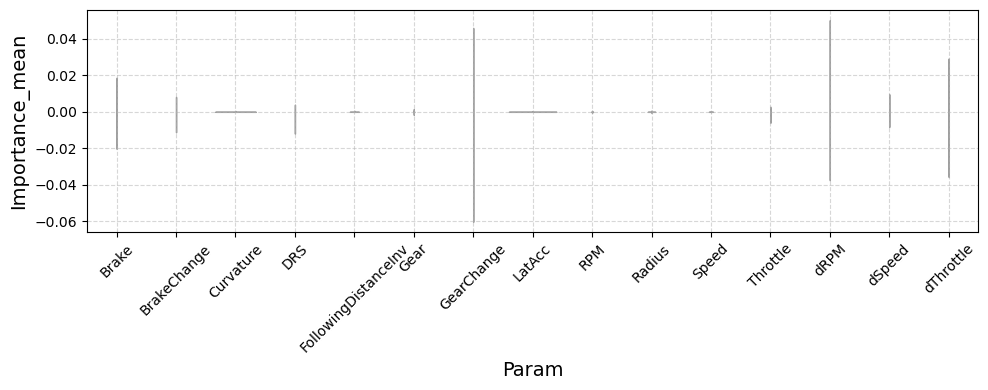

In [11]:
plot_violins(
    df_attr_stats,
    'Param',
    'Importance_mean',
    filter_by={'ModelName':['TelemetryModelFC'],
               'Task':['reg']},
    figsize=(10, 4))

### Parameter Importance: Classification

*   **Attribution Interpretation**

    In the classification task, near-zero attribution values indicate that a feature at a given circuit location did not meaningfully influence the model’s prediction. This may be because the feature was irrelevant, redundant with other inputs, or simply less informative than features at locations where the model relied more heavily.

    Positive attribution values suggest that a feature contributed evidence in favor of the correct driver, while negative values indicate that it misled the model—i.e., it supported an incorrect driver identity.

*   **Attribution Errors**

    Both high positive and negative attributions were observed, implying that the model frequently made incorrect inferences at specific locations—despite achieving high overall accuracy. This underscores a key point: a model can arrive at a correct final prediction while relying on a mix of correct and incorrect local cues.
    For instance, if a model favors the correct driver twice as often as any other at a given location, it will still make the correct prediction overall—even if a non-negligible number of features at that location contributed evidence for incorrect identities.

*   **Attribution Importance Along the Lap**

    For the FC and CNN models (both of which performed well at the classfication task), aggregate feature importance tended to peak in corners and chicanes rather than on straights, suggesting that more technically demanding segments of the circuit were more discriminative of driver behavior.

    Importantly, the spatial distribution of feature importance was logically consistent with expected driving behavior. For example, Brake importance was concentrated in braking zones, while DRS importance was limited to DRS zones on straights. In contrast, dRPM exhibited broader importance across the circuit, reflecting the fact that drivers modulate RPM more frequently than they apply the brakes.

*   **LIMITATIONS**

    The models may not assign importance to parameters evenly along the circuit. For example, they may focus on segments where a parameter has a pronounced effect and overlook regions where its influence is more subtle, assigning them near-zero importance.

### Parameter Importance: Regression

*   **Attribution Interpretation**

    In the regression task, near-zero attribution values indicate that a feature at a given location did not meaningfully influence the deviation of the predicted lap time from the baseline feature value at that point. This may occur if the feature was irrelevant, redundant with other inputs, or more informative at other locations on the lap where the model relied on it more heavily.

    Positive attribution values suggest that the feature contributed to predicting a slower (i.e., longer) lap time, while negative values indicate that it contributed to a faster (i.e., shorter) lap time relative to the baseline.

    The baseline was defined as the mode for discrete parameters and the median for continuous ones. Thus, near-zero attributions can also reflect that the driver’s behavior closely matched the baseline at that location. Conversely, non-zero attributions imply a meaningful deviation from the baseline that influenced the predicted lap time.

    A regression model may adopt two broad strategies for prediction. One approach is to rely on general indicators of slowing down or speeding up—such as interpreting downshifting as a sign of time loss. A more sophisticated model, however, may recognize the strategic value of such behaviors; for instance, timely downshifting before a chicane can enable smoother cornering and better exit speed, ultimately resulting in a faster lap.

*   **Attribution Errors**

    As reflected by the relatively high model errors, regression models can also misinterpret feature contributions—for example, incorrectly attributing slower lap times to beneficial actions or vice versa. Such errors may arise from limited training data, overfitting to local patterns, or an incomplete understanding of long-term driver behavior.

    Unlike in classification—where the final prediction is driven by the strongest signal—the regression task integrates contributions from all features and positions. As a result, inference errors accumulate rather than cancel out, making regression models more vulnerable to compounding mistakes. This likely explains their poorer performance: incorrect local attributions directly degrade the final output.

    Among the four models, the FC model exhibited the most noise in its parameter importance traces along the circuit. This likely stems from its lack of spatial and temporal context—provided by CNN and LSTM layers, respectively—making it more sensitive to local fluctuations in driving behavior.

*   **Attribution Importance Along the Lap**

    Across all models, aggregate attribution values were near zero along long straights, suggesting that drivers either did not deviate significantly from baseline behavior in those regions, or that such deviations did not meaningfully impact the predicted lap time.

    Where parameters were important, their spatial patterns aligned well with expected driving behavior. For instance, Brake importance was concentrated in braking zones, while DRS importance appeared primarily on long straights. The importance of dRPM was more broadly distributed, especially along wider circuit segments—consistent with the fact that drivers modulate RPM more frequently than they engage DRS or apply the brakes.

    Importantly, the models differed widely in how they interpreted the effect of driving behavior on lap times. For example, downshifting at the corner 11 entry was intertrepeted as having a positive (i.e. slowing down) attribution by the LSTM model, but solely a negative attribution (i.e. speeding up) attribution by the CNN model.

*   **LIMITATIONS**

    The models may not assign importance to parameters evenly along the circuit. For example, they may focus on segments where a parameter has a pronounced effect and overlook regions where its influence is more subtle, assigning them near-zero importance.

### Parameter Importance: Multi-Task

In the multi-task setting, only the FC and CNN models maintained performance levels comparable to those observed in the single-task modes.

*   **Attribution Importance Along the Lap** <br>

    Both models continued to assign minimal importance to features along the long straights in both task arms, suggesting that driver behavior in these segments did not vary significantly and contributed little to overall lap time predictions.

    The spatial distribution of individual parameter importance remained consistent with expected driving behavior. Brake importance was concentrated in braking zones, DRS in DRS zones on straights, and other frequently modulated parameters (e.g., dRPM, GearChange) exhibited broader importance along the circuit.

*   **Correspondance Between Classification and Regression Arms** <br>

    There was a high degree of correspondence in parameter importance along the circuit between the classification and regression arms, indicating that the multi-task models learned to focus on features relevant to both driver identity and lap time prediction.

    Notably, this correspondence was observed even when the models were trained on each task separately, suggesting a shared underlying structure in the learned representations.

*   **Attribution Erros** <br>

    In the classification arm of the multi-task setting, both FC and CNN models continued to produce both positive and negative attributions, indicating that incorrect inferences still occurred at individual circuit locations—despite high overall classification accuracy.

    In the regression arm, both models continued to show relatively high mean squared errors (~0.25), highlighting that inference errors were frequent and compounded over the lap, leading to deviations from true lap times.



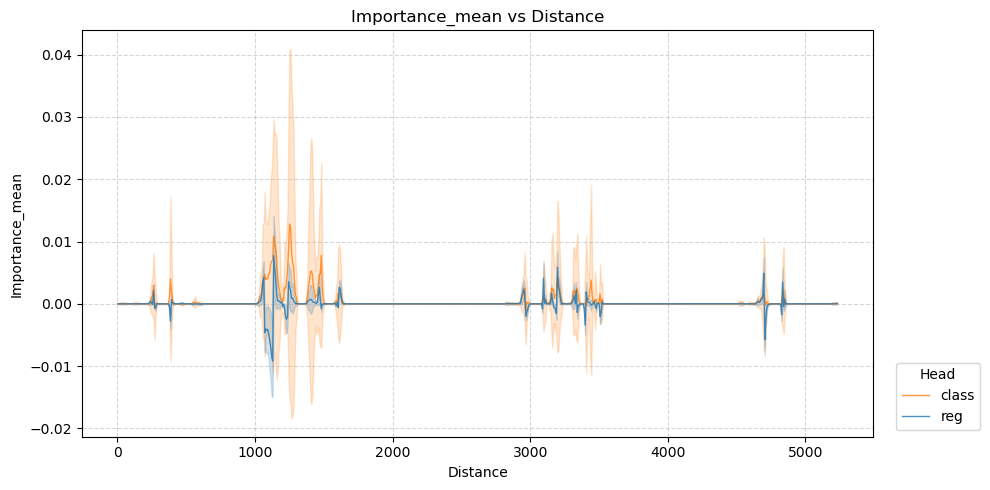

In [ ]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='Head',
    filter_by={
        'ModelName': [
            'TelemetryModelFC',
            #'TelemetryModelCNN',
            #'TelemetryModelLSTM',
            #'TelemetryModelCNNLSTM',
        ],
        'Task': ['multi'],
        'Param':['Brake'],
    },
    #limit_by={'Distance':(2750, 3750)},
)

### Regression Model Selection

*   **Model Selection Approach**

    Because regression models varied widely in their assignment of positive and negative attributions to individual parameters, attribution traces along the circuit were compared against driver segment times to assess interpretability. Two drivers were selected for comparison: Driver 81 (PIA), the race winner, and Driver 18 (STR), the last finisher.

    Segment times were computed over 200-meter intervals, and segments with the largest performance differences were identified. For instance, PIA was consistently and significantly faster between 3000–3400 m. If the regression models truly captured meaningful driving behavior—rather than overfitting to data—they would be expected to assign negative attributions to PIA and positive attributions to STR in these segments.

*   **Model Attributions for Gear & GearChange Parameters**

    All models identified GearChange—and to a lesser extent Gear—as important parameters.

    In the single-task mode, only the FC model assigned a strong negative attribution to GearChange for PIA and a slightly positive attribution for STR around 3000–3400 m. The remaining three models failed to capture this substantial performance difference between the drivers. For the related Gear parameter, both the FC and CNN models exhibited the expected attribution pattern—negative for PIA and positive for STR—although both models generally emphasized GearChange over Gear. These findings suggest that the FC model was more effective at regressing lap times in a way that produced logically consistent insights into driver behavior, rather than merely overfitting to the training data.

    In the multi-task mode, both the FC and CNN models assigned a strong negative attribution to PIA for GearChange in the same segment (3000–3400 m), suggesting that the CNN model was better able to meaningfully regress lap times in the multi-task setting.

    To further investigate, telemetry data from the two drivers was compared directly. At the entry to Corner 11 (approximately 3000 m), telemetry traces revealed that STR downshifted earlier than PIA. The FC regression model (as well as FC and CNN multi-task models) assigned a positive attribution to STR’s early gear change and a negative attribution to PIA’s later downshift, suggesting that the timing of the gear change contributed to PIA’s faster segment time through this portion of the circuit.

*   **Model Attributions for Brake Parameter**

    In the single-task mode, once again only the FC regression model captured the expected attribution pattern for Brake—negative for PIA and positive for STR—around 3000 m. Telemetry traces showed that STR began braking earlier than PIA when entering Corner 11, suggesting that PIA’s later braking contributed to his faster segment time in that portion of the track.

    In the multi-task mode, the CNN model’s attribution aligned more closely with expected behavior, assigning a more positive Brake attribution to STR than to PIA at the entry to Corner 11. This suggests that, in the multi-task setting, the CNN model better captured the performance implications of braking behavior in this segment.

*   **Model Attributions for dRPM Parameter**

    In the single-task mode, both the FC and CNN-LSTM regression models captured the expected attribution pattern for dRPM around 3000 m. Telemetry data showed that PIA modulated RPM more dynamically than STR, with more pronounced drops and increases. This suggests that more refined RPM modulation may have contributed to PIA’s faster execution of Corner 11.

    In the multi-task mode, the CNN model again produced more consistent and interpretable results, assigning a more strongly negative dRPM attribution to PIA than to STR—further aligning with the observed performance difference.

*   **Model Attributions for dThrottle Parameter**

    In the single-task mode, all models assigned similar attribution values for both drivers, suggesting that throttle modulation in this part of the circuit did not meaningfully contribute to predicted lap times.

    In the multi-task mode, the FC model continued to assign comparable attributions to both drivers. In contrast, the CNN model assigned a more positive attribution to PIA, contradicting his superior segment time and the attribution patterns observed in other models.

    Telemetry traces showed that, at the entry to Corner 11, STR reduced throttle over a longer stretch, while PIA executed a sharper, more abrupt throttle drop. However, the overall throttle reduction—approximated by the area under the curve—was similar for both drivers. This supports the idea that dThrottle modulation was not a key differentiator of performance in this segment and likely should not have been assigned high importance.

**Overall Model Interpretability**

Among the four regression models in the single-task mode, the FC model most consistently produced parameter attributions that aligned with observed segment times and expected driving behavior. This suggests that it was the most effective at capturing meaningful relationships between telemetry features and lap time performance in this setting.

In the multi-task mode, both the FC and CNN models generally produced attributions consistent with observed driver performance, reflecting improved interpretability compared to their behavior in the single-task mode.

The relatively strong performance of the simple FC model was somewhat unexpected. Its advantage over more complex recurrent architectures such as LSTM and CNN-LSTM may be explained by data limitations, as these models typically require larger datasets to generalize effectively. The CNN architecture, while slightly more complex than FC, is designed to capture spatial context through convolutional filters that aggregate information across neighboring inputs. However, if the telemetry data is sparsely sampled, the CNN may miss fine-grained temporal features, potentially explaining the more stable and interpretable behavior of the FC model.

**LIMITATIONS**

*   **Data fidelity**: Small misalignments in track position can cause shifts in telemetry traces, potentially leading to spurious attribution differences.
*   **Model generalization**: Although the regression models captured some meaningful patterns, their performance (e.g., MSE ≈ 0.25) suggests residual error and the possibility of misattributed importance.
*   **Causal ambiguity**: Attributions derived from telemetry data reflect statistical associations rather than causal mechanisms. Performance differences may stem from other unmodeled factors such as car setup, tire wear, energy deployment strategies, or track conditions.

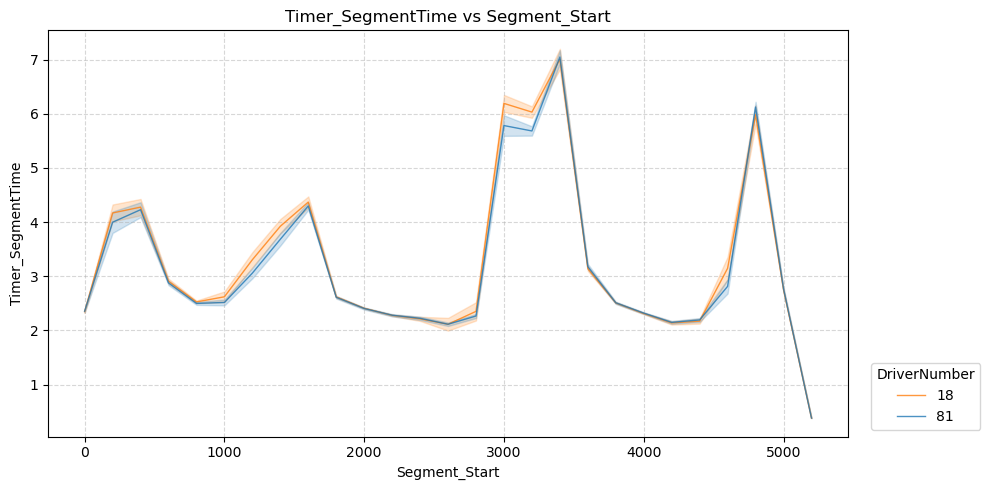

In [13]:
plot_traces(
    df=df_stats,
    x_col='Segment_Start',
    y_col=('Timer','SegmentTime'),
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 18],
    },
    #limit_by={'Segment_Start':(2750, 3750)},
)

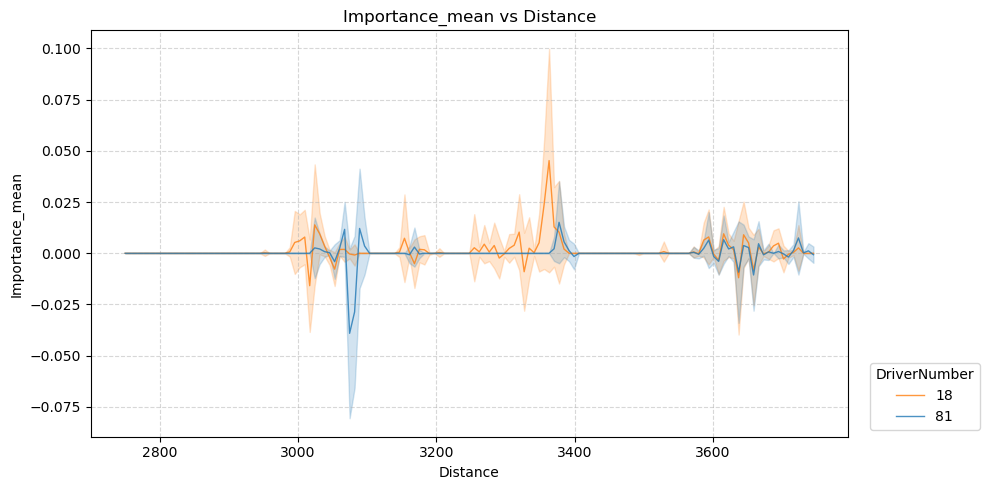

In [14]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='DriverNumber',
    std_col='Importance_std',
    filter_by={
        'ModelName': ['TelemetryModelFC'],
        'Task': ['multi'],
        'Head':['reg'],
        'Param':['GearChange'],
        'DriverNumber': [81, 18],        
    },
    limit_by={'Distance':(2750, 3750)},
)

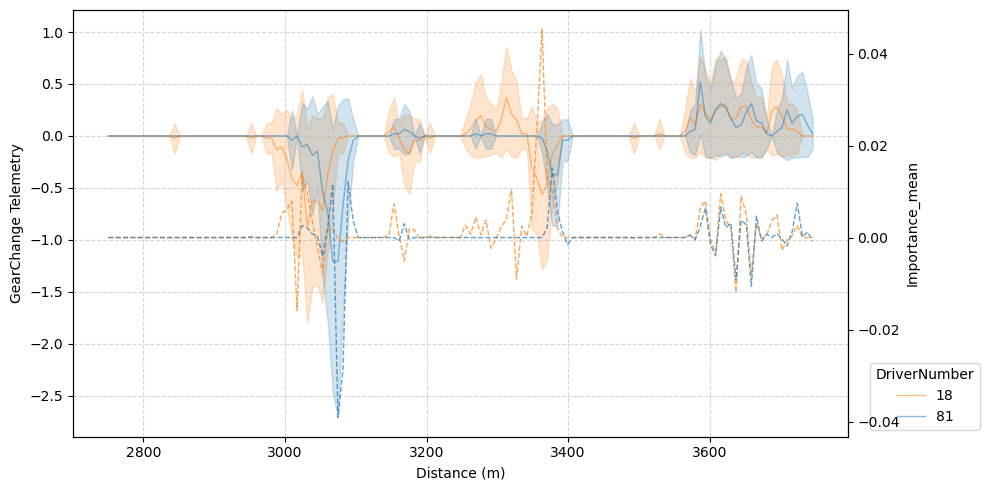

In [15]:
overlay_telemetry_and_importance_traces(
    df_tel=df_tel,
    df_attr=df_attr_stats,
    y_col_tel='GearChange',
    y_col_attr='Importance_mean',
    group_col='DriverNumber',
    filter_by={
        'ModelName':['TelemetryModelFC'],
        'Task':['multi'],
        'Head':['reg'],
        'DriverNumber': [81, 18],
    },
    limit_by={'Distance':(2750, 3750)},
)

### Driver Comparison (McLaren vs Ferrari)

*   **Driver Comparison Approach**

    Four drivers from two teams were selected for comparison: Drivers 81 (PIA) and 4 (NOR) from McLaren, and Drivers 16 (LEC) and 44 (HAM) from Ferrari.

    Segment times were computed over 200 m intervals and plotted against track distance. The most pronounced differences appeared around Corner 11, where PIA consistently outperformed the other three drivers between 3000–3200 m, before losing this advantage later in the chicane.

    Attribution traces were examined for the five parameters identified as most influential overall: GearChange, dRPM, dThrottle, Brake, and dSpeed. This analysis revealed which telemetry parameters—and which segments of the chicane—were most strongly associated with performance differences. Follow-up inspection of telemetry at these positions uncovered several driving behaviors linked to faster segment times.

*   **GearChange (strongest attribution)**

    GearChange exhibited the strongest negative attribution peak for PIA ~3075 m, suggesting that his gear modulation at the chicane entry may have contributed to his faster segment times. Telemetry traces confirmed that PIA generally delayed his downshifts relative to the others. NOR and LEC initiated downshifting earliest, while HAM displayed intermediate timing. Delayed downshifting may have preserved speed and momentum further into the corner.

*   **dThrottle (medium attribution)**

    dThrottle attribution traces showed the most pronounced negative peak for PIA around 2940 m, with NOR exhibiting a smaller, overlapping negative peak. In contrast, both Ferrari drivers (LEC and HAM) displayed positive attribution peaks at the same location, as well as another positive peak around 2075 m. Telemetry traces indicated that all drivers started to lift the throttle around the same track position. However, the McLaren drivers lifted the throttle more abruptly, reaching peak dThrottle value ~2925 m, whereas the Ferrari drivers lifted it more gradually, reaching the peak ~2975 m. Possibly, more abrupt throttle release helped with front-end grip through the corner.

*   **Brake (weakest attribution)**

    Brake attribution curves were broadly similar across all four drivers and were of lowest importance. At chicane entry (~2950 m), PIA exhibited the shortest positive attribution peak, while HAM showed the tallest. Brake telemetry confirmed that PIA braked slightly later than the others.

    However, information derived from the brake parameter is limited, likely because only binary data is available through fastf1 module, i.e. information on how hard the drivers press on the brake is not available.

*   **dRPM (medium attribution)**

    dRPM parameter showed several attribution importance peaks in the region of interest, with NOR exhibiting a negative peak ~2950 m, PIA and HAM - negative overlapping peaks ~3000 m, and PIA - an additional negative peak ~3040 m. However, RPM is influenced indirectly via throttle, brake, and gear inputs, so isolating its direct causal effect is challenging.

    Between 2875–2930 m, RPM dropped gently, likely with throttle lift; only NOR briefly increased RPM, which the model linked to medium gains ~2950 m.

    Between 2930–3020 m, RPM dropped more steeply, likely with braking; PIA and HAM showed the fastest drop (more negative dRPM) between 2950–3000 m, which correlated with medium gains ~3000 m—likely from more compressed braking, improved front-end grip, and reaching optimal pre-shift RPM for stability. PIA’s delayed downshift may have allowed him to achieve this steep RPM drop without losing relative speed to the other drivers.

    Around 3050 m, RPM spiked again, likely with downshifts; PIA’s later shift from a lower pre-shift RPM produced the sharpest rebound (highest dRPM) and correlated with medium time gains, likely placing the engine squarely in the optimal power band. While all drivers continued to decelerate through this phase, PIA shed speed more gradually, maintaining a relative RPM and speed advantage over the others until ~3100 m.

*   **dSpeed**

    For PIA, both Speed and dSpeed attribution traces were consistently more negative than those of the other drivers. Telemetry confirmed that PIA decelerated more gradually into the chicane and maintained his speed advantage between 3025-3100 m.

*   **Conclusions**

    Attribution and telemetry analyses suggest that PIA’s faster execution of Corner 11 can be attributed to a combination of a more abrupt throttle release ~2925 m, later braking ~2930 m, a later and more precise downshifting ~3060 m, and a more dynamic modulation of the RPM, .

*   **LIMITATIONS**

    **Data fidelity**: Small misalignments in track position can cause shifts in telemetry traces, potentially leading to spurious attribution differences.
    **Model generalization**: Although the regression models captured some meaningful patterns, their performance (e.g., MSE ≈ 0.25) suggests residual error and the possibility of misattributed importance.
    **Causal ambiguity**: Attributions derived from telemetry data reflect statistical associations rather than causal mechanisms. Performance differences may stem from other unmodeled factors such as car setup, tire wear, energy deployment strategies, or track conditions.

Plot saved to ../data/miami_2025/circuit.png


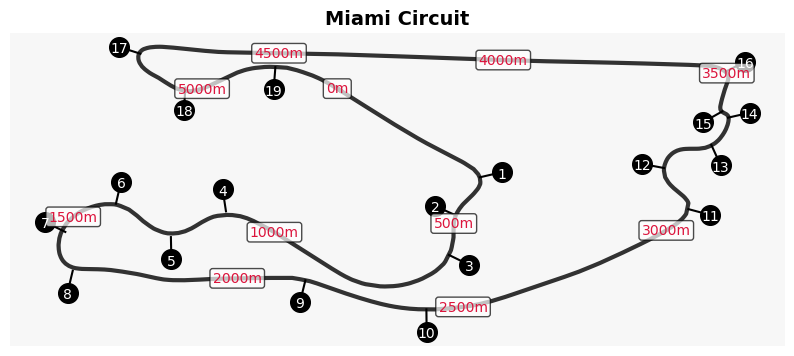

In [34]:
visualize_circuit(session=miami_2025, save_path='../data/miami_2025/circuit.png')

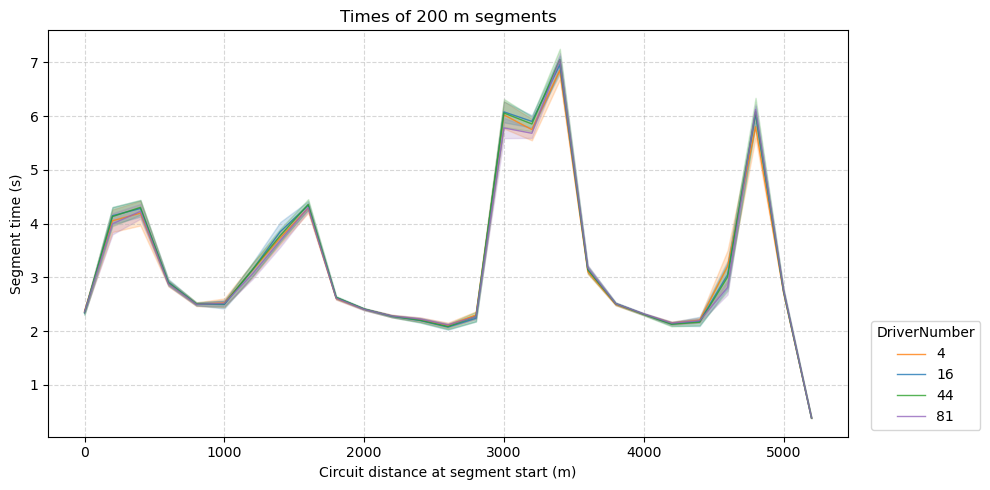

In [17]:
plot_traces(
    df=df_stats,
    x_col='Segment_Start',
    y_col=('Timer','SegmentTime'),
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],
    },
    #limit_by={'Segment_Start':(2800, 3600)},
    xlabel='Circuit distance at segment start (m)',
    ylabel='Segment time (s)',
    title='Times of 200 m segments',
    #save_path='../data/miami_2025/plots/segment_times.png',
)

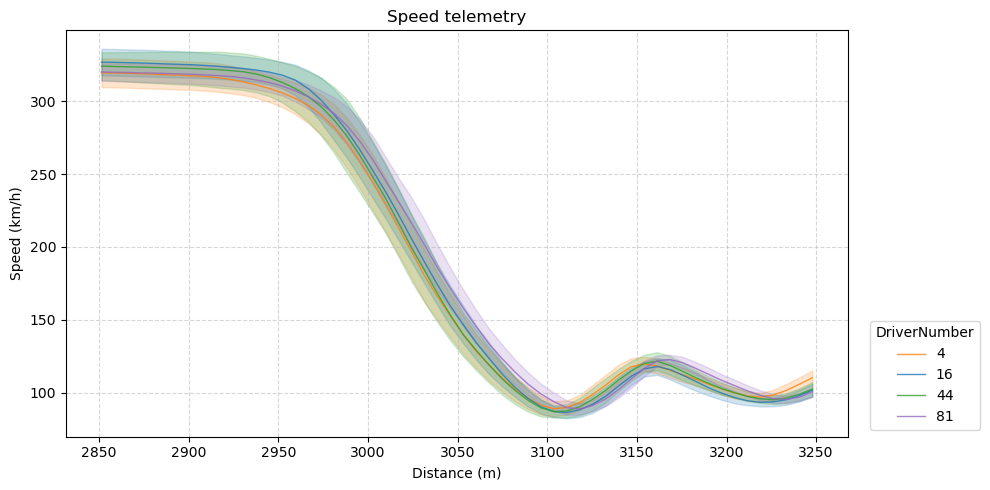

In [18]:
plot_traces(
    df=df_tel,
    x_col='Distance',
    y_col='Speed',
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Speed (km/h)',
    title='Speed telemetry',
    #save_path='../data/miami_2025/plots/Speed_telemetry.png',
)

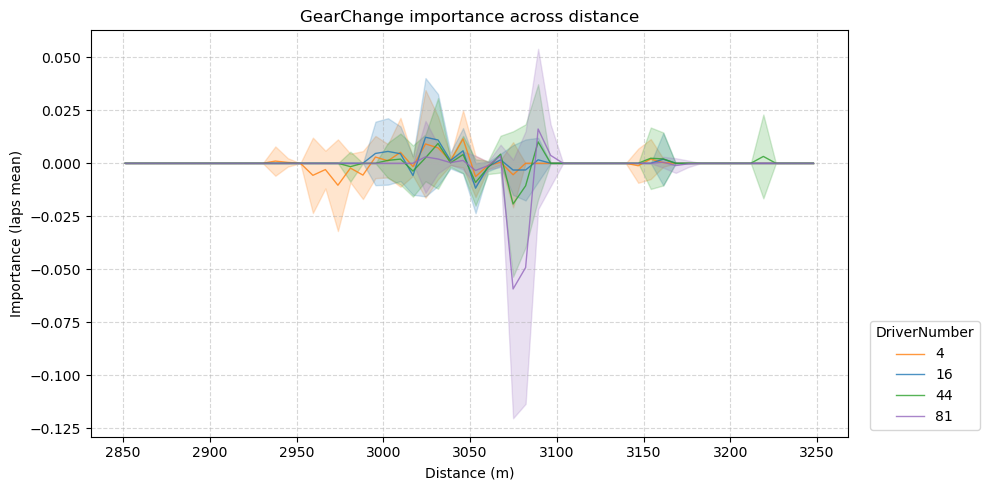

In [19]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='DriverNumber',
    std_col='Importance_std',
    filter_by={
        'ModelName': ['TelemetryModelFC'],
        'Task': ['reg'],
        'Head':['reg'],
        'Param':['GearChange'],
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Importance (laps mean)',
    title='GearChange importance across distance',
    #save_path='../data/miami_2025/plots/GearChange_importance.png',
)

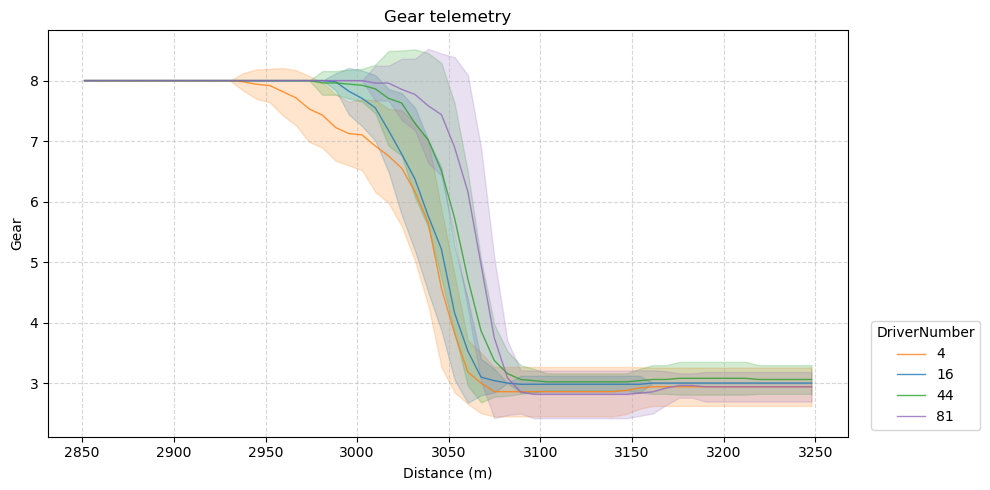

In [20]:
plot_traces(
    df=df_tel,
    x_col='Distance',
    y_col='Gear',
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Gear',
    title='Gear telemetry',
    #save_path='../data/miami_2025/plots/Gear_telemetry.png',
)

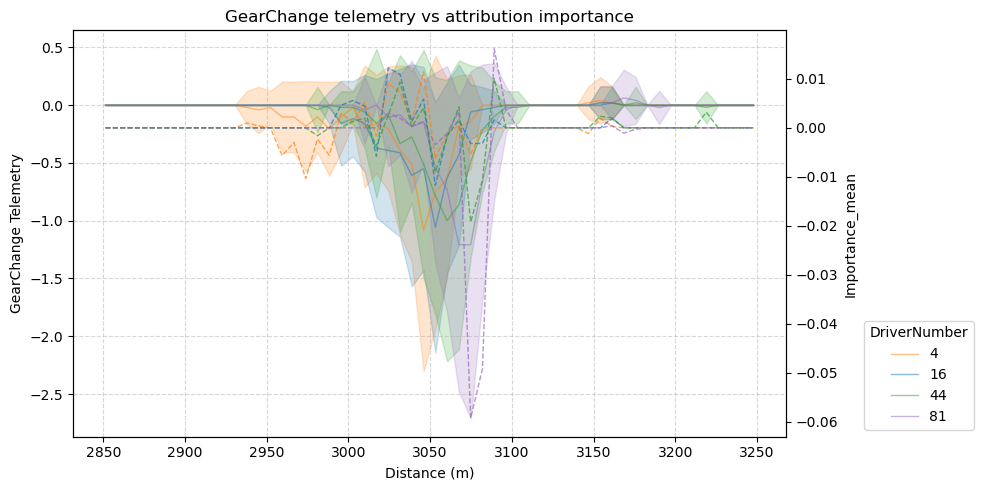

In [7]:
overlay_telemetry_and_importance_traces(
    df_tel=df_tel,
    df_attr=df_attr_stats,
    y_col_tel='GearChange',
    y_col_attr='Importance_mean',
    group_col='DriverNumber',
    filter_by={
        'ModelName':['TelemetryModelFC'],
        'Task':['reg'],
        'Head':['reg'],
        'DriverNumber': [81, 4, 16, 44],
    },
    limit_by={'Distance':(2850, 3250)},
    title='GearChange telemetry vs attribution importance',
)

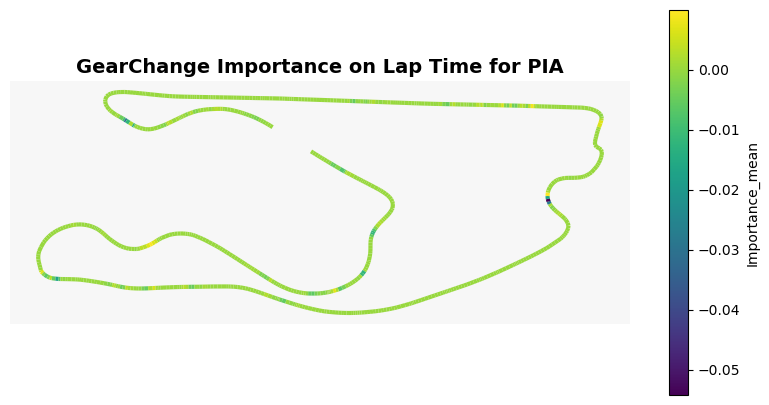

In [36]:
visualize_along_circuit_ind_values(
    df=df_attr_stats,
    z_col='Importance_mean',
    filter_by={
        'ModelName':['TelemetryModelFC'],
        'Task':['reg'],
        'Param':['GearChange'],
        'DriverNumber':[81],
    },
    title='GearChange Importance on Lap Time for PIA',
    #save_path='../data/miami_2025/plots/GearChange_Importance_PIA.png'
)

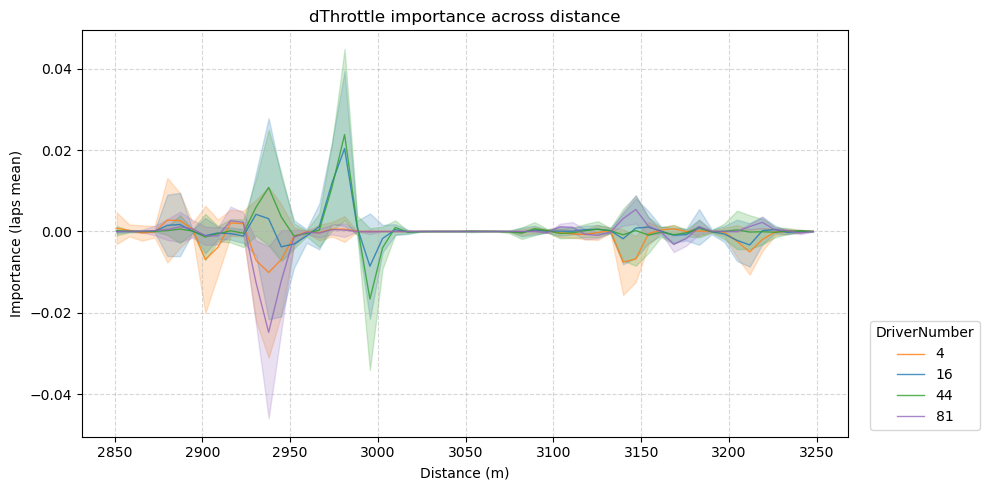

In [22]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='DriverNumber',
    std_col='Importance_std',
    filter_by={
        'ModelName': ['TelemetryModelFC'],
        'Task': ['reg'],
        'Head':['reg'],
        'Param':['dThrottle'],
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Importance (laps mean)',
    title='dThrottle importance across distance',
    #save_path='../data/miami_2025/plots/dThrottle_importance.png',
)

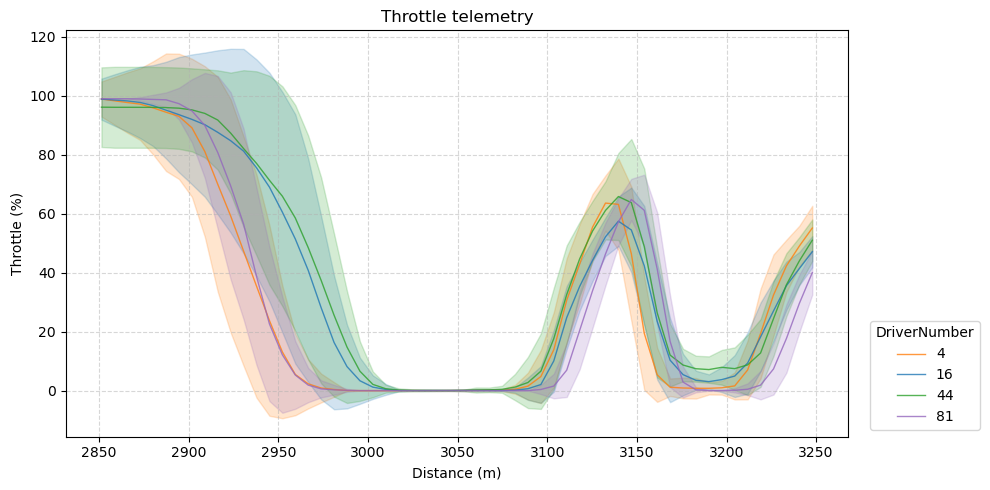

In [23]:
plot_traces(
    df=df_tel,
    x_col='Distance',
    y_col='Throttle',
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Throttle (%)',
    title='Throttle telemetry',
    #save_path='../data/miami_2025/plots/Throttle_telemetry.png',
)

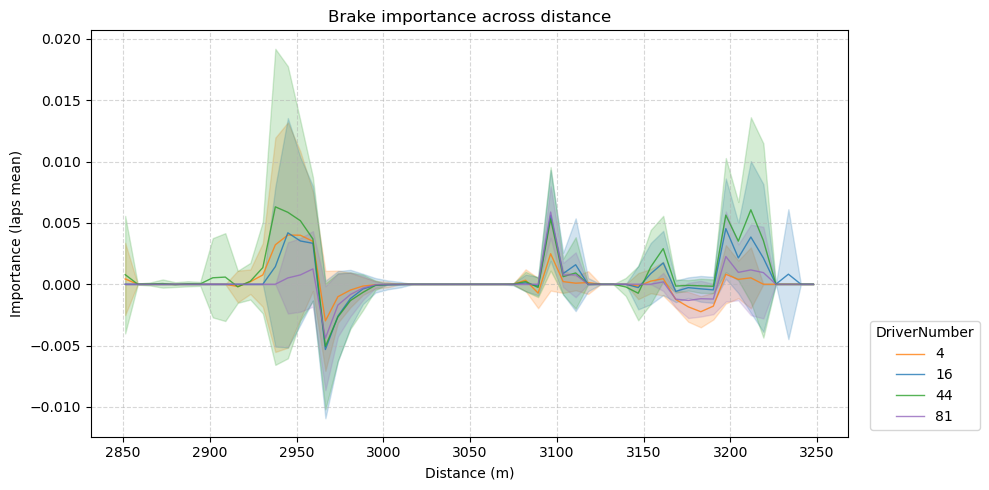

In [24]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='DriverNumber',
    std_col='Importance_std',
    filter_by={
        'ModelName': ['TelemetryModelFC'],
        'Task': ['reg'],
        'Head':['reg'],
        'Param':['Brake'],
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Importance (laps mean)',
    title='Brake importance across distance',
    #save_path='../data/miami_2025/plots/Brake_importance.png',
)

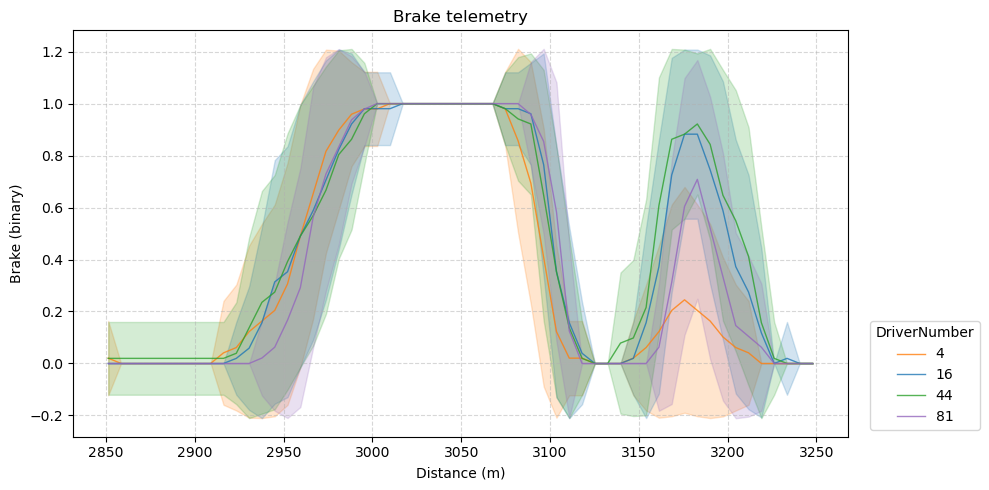

In [25]:
plot_traces(
    df=df_tel,
    x_col='Distance',
    y_col='Brake',
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Brake (binary)',
    title='Brake telemetry',
    #save_path='../data/miami_2025/plots/Brake_telemetry.png',
)

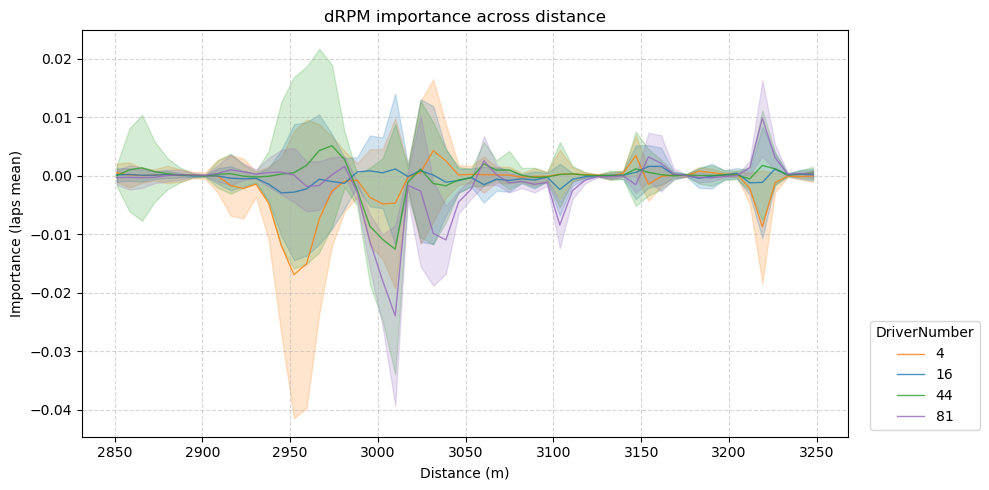

In [26]:
plot_traces(
    df=df_attr_stats,
    x_col='Distance',
    y_col='Importance_mean',
    group_col='DriverNumber',
    std_col='Importance_std',
    filter_by={
        'ModelName': ['TelemetryModelFC'],
        'Task': ['reg'],
        'Head':['reg'],
        'Param':['dRPM'],
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='Importance (laps mean)',
    title='dRPM importance across distance',
    #save_path='../data/miami_2025/plots/dRPM_importance.png',
)

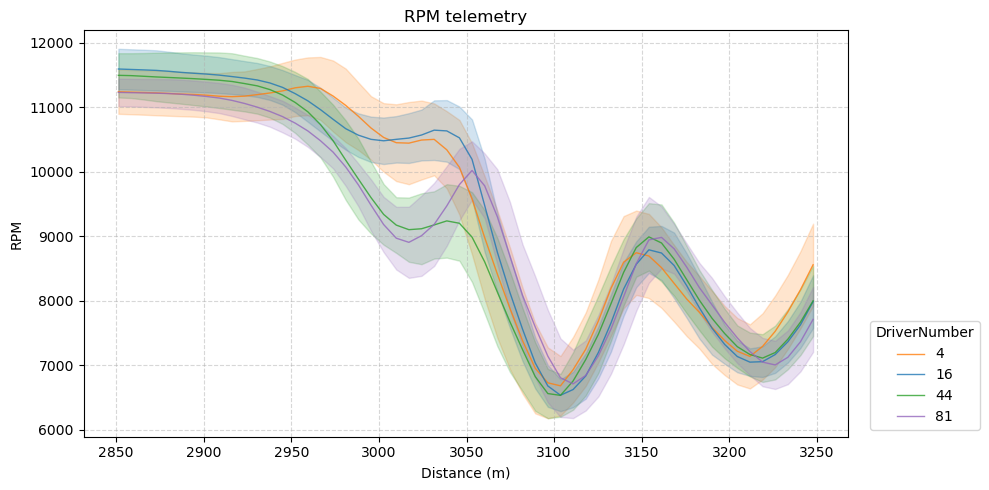

In [27]:
plot_traces(
    df=df_tel,
    x_col='Distance',
    y_col='RPM',
    group_col='DriverNumber',
    filter_by={
        'DriverNumber': [81, 4, 16, 44],        
    },
    limit_by={'Distance':(2850, 3250)},
    xlabel='Distance (m)',
    ylabel='RPM',
    title='RPM telemetry',
    #save_path='../data/miami_2025/plots/RPM_telemetry.png',
)